In [15]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal.windows import gaussian
from scipy.ndimage import gaussian_filter

In [2]:
y, sr = librosa.load(librosa.example("libri1"), sr=None)

In [11]:
suby = y[2000:6000]

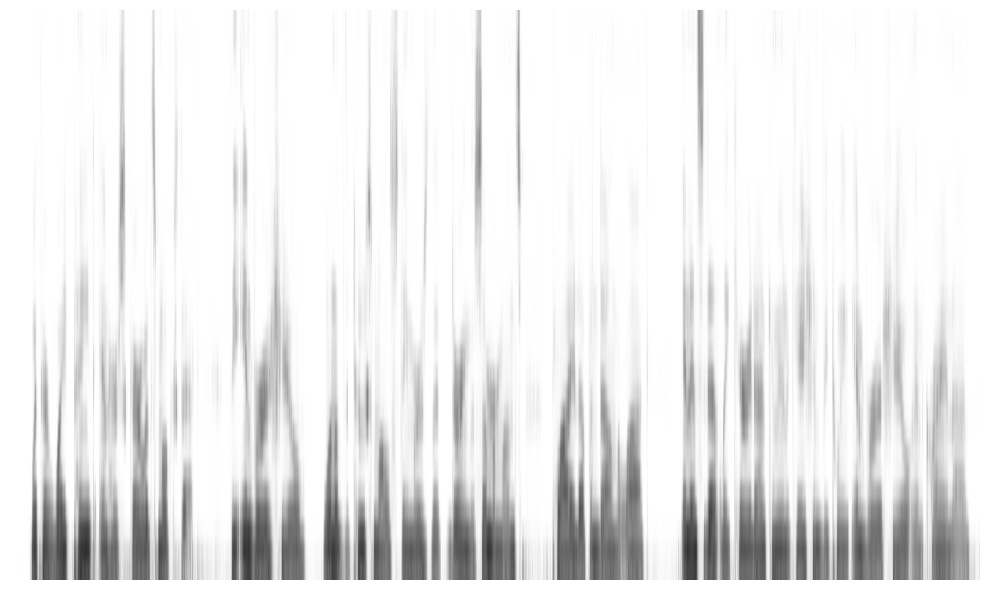

In [31]:
window_length = int(0.005 * sr)  # ~5 ms window length
hop_length = int(0.001 * sr)    # ~1 ms hop length for good time resolution
n_fft = int(2 ** np.ceil(np.log2(window_length)))  # FFT size matching window length

# Generate Gaussian window
gaussian_window = gaussian(window_length, std=window_length / 6)

# Compute STFT with Gaussian window
D = librosa.stft(y, n_fft=n_fft, hop_length=hop_length, win_length=window_length, window=gaussian_window)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

# Apply dynamic range cutoff
dynamic_range = 50  # Praat's dynamic range
S_db = np.clip(S_db, a_min=S_db.max() - dynamic_range, a_max=None)

# Frequency range (e.g., 0 to 5000 Hz for speech analysis)
max_freq = 5000  # in Hz
max_bin = int(max_freq / (sr / n_fft))

# Plot in grayscale with no interpolation
plt.figure(figsize=(10, 6))
plt.imshow(
    S_db[:max_bin, :], aspect="auto", origin="lower", cmap="Greys",
    extent=[0, len(y) / sr, 0, max_freq]  # No interpolation
)
plt.axis("off")  # Hide axes for a clean display
plt.tight_layout()
plt.show()

In [ ]:
!sudo apt update
!sudo apt install libcairo2-dev \
    texlive texlive-latex-extra texlive-fonts-extra \
    texlive-latex-recommended texlive-science \
    tipa libpango1.0-dev
!pip install manim

In [22]:
from manim import *
import numpy as np
import librosa

In [29]:
%%manim -qm -v WARNING MovingWindowAnalysis

class MovingWindowAnalysis(Scene):
    def construct(self):
        # Load audio signal
        y, sr = librosa.load(librosa.example("trumpet"), sr=None)
        start_sample = 0  # Starting sample for visualization
        end_sample = 4000  # Ending sample for visualization
        y = y[start_sample:end_sample]

        # Parameters for the sliding window
        window_length = 512
        hop_length = 128  # Step size for the window
        hamming_window = np.hamming(window_length)
        num_frames = (len(y) - window_length) // hop_length

        # Frame-based x-axis for the wave graph
        num_total_frames = len(y)
        frame_axis = np.linspace(0, num_total_frames, len(y))
        freq_axis = np.fft.rfftfreq(window_length, 1 / sr)

        # Create axes for the wave graph
        wave_axes = Axes(
            x_range=[0, num_total_frames, num_total_frames // 3],  # Label every third point
            y_range=[-0.5, 0.5, 0.1],
            x_length=10,
            y_length=3,
            axis_config={"include_numbers": True},
            tips=False
        ).to_edge(UP)

        wave_graph = wave_axes.plot(
            lambda x: np.interp(x, frame_axis, y),
            x_range=[0, num_total_frames],
            color=BLUE
        )

        # Add frame-based x-axis label below the plot
        wave_axes.add(Tex("Frames").next_to(wave_axes, DOWN))

        # Create axes for FFT
        fft_axes = Axes(
            x_range=[0, 8000, 1000],
            y_range=[-50, 10, 10],
            x_length=10,
            y_length=3,
            axis_config={"include_numbers": True},
            tips=False
        ).to_edge(DOWN)

        fft_graph = fft_axes.plot(
            lambda x: 0,
            x_range=[0, 8000],
            color=GREEN
        )

        # Add frequency-based x-axis label below the plot
        fft_axes.add(Tex("Frequency (Hz)").next_to(fft_axes, DOWN))

        # Create the initial window rectangle
        window_highlight = Rectangle(
            width=window_length / len(y) * wave_axes.x_length,
            height=0.5,
            color=RED,
            fill_opacity=0.3
        ).align_to(wave_axes.c2p(0, 0), LEFT)

        # Add all components to the scene
        self.add(wave_axes, fft_axes, wave_graph, fft_graph, window_highlight)

        # Animation function
        def update_fft_and_window(frame):
            # Compute window start and end indices
            window_start = frame * hop_length
            window_end = window_start + window_length

            # Apply Hamming window to the segment
            segment = y[window_start:window_end] * hamming_window
            fft_result = np.fft.rfft(segment)
            fft_magnitude_db = 10 * np.log10(np.abs(fft_result) ** 2 + 1e-10)

            # Update FFT graph
            new_fft_graph = fft_axes.plot(
                lambda x: np.interp(x, freq_axis, fft_magnitude_db),
                x_range=[0, 8000],
                color=GREEN
            )

            # Update window rectangle position
            new_window_highlight = window_highlight.copy()
            new_window_highlight.move_to(wave_axes.c2p(
                window_start / num_total_frames * wave_axes.x_range[1], 0
            ), LEFT)

            return new_fft_graph, new_window_highlight

        # Animate the window moving and FFT updating
        for frame in range(num_frames):
            new_fft_graph, new_window_highlight = update_fft_and_window(frame)
            self.play(
                Transform(fft_graph, new_fft_graph),
                Transform(window_highlight, new_window_highlight),
                run_time=0.2
            )


Manim Community v0.19.0

In [49]:
%%manim -qm -v WARNING CosineTransformIllustration

class CosineTransformIllustration(Scene):
    def construct(self):
        # Phase 1: Display the formula and input signal spectrum
        title = Text("Cosine Transform", font_size=48).to_edge(UP)
        self.play(Write(title))

        formula = MathTex(
            r"C_j = \sqrt{\frac{2}{N}} \sum_{i=1}^{N} A_i \cos\left(\frac{j\pi (i - 0.5)}{N}\right)",
            font_size=36
        ).next_to(title, DOWN, buff=0.5)
        self.play(Write(formula))
        self.wait(2)

        # Input signal spectrum visualization
        ai_graph_label = Tex(r"$A_i$: Spectrum of input signal").to_edge(LEFT).shift(UP)
        ai_graph = Axes(
            x_range=[0, 16, 1], y_range=[0, 100, 20],
            axis_config={"include_numbers": True},
            x_length=5, y_length=3
        ).shift(LEFT * 2 + DOWN * 1.5)
        spectrum_curve = ai_graph.plot(
            lambda x: 80 - 4 * x + (x % 3) * 10, x_range=[0, 15], color=BLUE
        )

        self.play(Write(ai_graph_label), Create(ai_graph), Create(spectrum_curve))
        self.wait(2)

        # Remove title and input signal before transitioning
        self.play(FadeOut(title, ai_graph_label, ai_graph, spectrum_curve, formula))
        self.wait(1)

        # Phase 2: Render cosine weights together
        weights_label = Tex(r"Cosine weights: $w_1, w_2, \ldots$", font_size=30).to_edge(UP)
        self.play(Write(weights_label))

        # Generate axes and curves for weights
        weight_graphs = VGroup()
        for i in range(4):  # Render all cosine weights together
            # Create individual axes with smaller size
            graph = Axes(
                x_range=[0, 16, 1], y_range=[-1, 1, 0.5],
                axis_config={"include_numbers": False},
                x_length=2.5,  # Reduced length
                y_length=1.5   # Reduced height
            ).shift(DOWN * (i - 1.5))  # Stack vertically

            # Create corresponding curve
            curve = graph.plot(
                lambda x: np.cos((i + 1) * np.pi * (x - 0.5) / 16),
                x_range=[0, 15], color=BLUE
            )
            graph.add(curve)
            weight_graphs.add(graph)

        # Center the group of graphs on the left side
        weight_graphs.arrange(DOWN, buff=0.5).to_edge(LEFT, buff=1.5)
        self.play(Create(weight_graphs))
        self.wait(2)

        # Phase 3: Render cepstrum outputs on the right
        cj_label = Tex(r"$C_j$: Cepstrum Coefficients", font_size=30).next_to(weights_label, RIGHT, buff=1.5)
        self.play(Write(cj_label))

        cj_bars = BarChart(
            values=[40, -20, 10, -5], bar_colors=[BLUE, RED, GREEN, ORANGE],
            y_range=[-60, 60, 20],
            x_length=4, y_length=3
        ).next_to(weight_graphs, RIGHT, buff=2)

        self.play(Create(cj_bars))
        self.wait(3)

        # Clean up
        self.play(FadeOut(weights_label, weight_graphs, cj_label, cj_bars))



Manim Community v0.19.0

In [60]:
%%manim -qm -v WARNING DTWSpellingExample

from manim import *

class DTWSpellingExample(Scene):
    def construct(self):
        # Specify the strings to align
        unknown = "ALLDRIG"
        reference = "ALDRIG"

        # Phase 1: Display the DTW algorithm
        title = Text("Dynamic Time Warping (DTW) Algorithm", font_size=36).to_edge(UP)
        self.play(Write(title))

        algorithm_text = Tex(
            r"""
            \raggedright
            \textbf{Algorithm:} \\
            1: \text{for } $h = 1$ \text{ to } $H$ \text{ do} \\
            2: \quad \text{for } $k = 1$ \text{ to } $K$ \text{ do} \\
            3: \quad \quad $AccD[h, k] = LocD[h, k] + \min($ \\
            \quad \quad \quad \quad $AccD[h - 1, k],$ \\
            \quad \quad \quad \quad $AccD[h - 1, k - 1],$ \\
            \quad \quad \quad \quad $AccD[h, k - 1])$ \\
            """,
            font_size=64,
        ).scale(0.9).to_edge(LEFT)

        self.play(Write(algorithm_text))
        self.wait(3)

        # Fade out the algorithm
        self.play(FadeOut(algorithm_text))

        # Phase 2: Local Distance Matrix
        local_dist_title = Text("Local Distance Matrix (LocD)", font_size=36).to_edge(UP)
        self.play(ReplacementTransform(title, local_dist_title))

        # Compute and display the local distance matrix
        locd_matrix = [[0 if c1 == c2 else 1 for c2 in reference] for c1 in unknown]
        locd_table = self.create_table(
            locd_matrix, unknown, reference, label="LocD[h, k]"
        )

        self.play(Create(locd_table))
        self.wait(3)

        # Phase 3: Accumulated Cost Matrix
        accd_title = Text("Accumulated Cost Matrix (AccD)", font_size=36).to_edge(UP)
        self.play(ReplacementTransform(local_dist_title, accd_title))

        accd_matrix = self.compute_accumulated_cost(locd_matrix)
        accd_table = self.create_table(
            accd_matrix, unknown, reference, label="AccD[h, k]"
        )

        self.play(Transform(locd_table, accd_table))
        self.wait(3)

        # Phase 4: Backtracking for Optimal Path
        path_title = Text("Backtracking for Optimal Path", font_size=36).to_edge(UP)
        self.play(ReplacementTransform(accd_title, path_title))

        path_arrows = self.backtrack_path(accd_matrix, accd_table[0], unknown, reference)
        self.play(Create(path_arrows))
        self.wait(3)

        # Phase 5: Final Result
        result_text = Tex(
            r"Alignment complete! Distance: "
            + str(accd_matrix[len(unknown) - 1][len(reference) - 1]),
            font_size=30,
        ).to_edge(DOWN)
        self.play(Write(result_text))
        self.wait(3)

    def create_table(self, matrix, rows, cols, label):
        """Creates a table from a matrix with row/column labels."""
        # Add row and column labels
        table_data = [[" "] + list(cols)] + [[row] + list(map(str, row_data)) for row, row_data in zip(rows, matrix)]

        table = Table(
            table_data,
            include_outer_lines=True,
            element_to_mobject_config={"color": WHITE},
        ).scale(0.6)

        label_text = Text(label, font_size=24).next_to(table, UP)
        return VGroup(table, label_text)

    def compute_accumulated_cost(self, locd_matrix):
        """Computes the accumulated cost matrix."""
        rows, cols = len(locd_matrix), len(locd_matrix[0])
        accd_matrix = [[0] * cols for _ in range(rows)]

        # Initialize the first cell
        accd_matrix[0][0] = locd_matrix[0][0]

        # Fill the first row
        for j in range(1, cols):
            accd_matrix[0][j] = accd_matrix[0][j - 1] + locd_matrix[0][j]

        # Fill the first column
        for i in range(1, rows):
            accd_matrix[i][0] = accd_matrix[i - 1][0] + locd_matrix[i][0]

        # Fill the rest of the matrix
        for i in range(1, rows):
            for j in range(1, cols):
                accd_matrix[i][j] = locd_matrix[i][j] + min(
                    accd_matrix[i - 1][j],    # From above
                    accd_matrix[i][j - 1],    # From left
                    accd_matrix[i - 1][j - 1] # From diagonal
                )

        return accd_matrix

    def backtrack_path(self, accd_matrix, table, rows, cols):
        """Backtracks to find the optimal path."""
        path_arrows = VGroup()
        i, j = len(rows), len(cols)

        while i > 1 or j > 1:
            # Current cell position
            current_cell = table.get_entries((i, j)).get_center()

            # Determine the previous cell based on accumulated cost values
            if i > 1 and j > 1 and accd_matrix[i - 1][j - 1] <= min(
                accd_matrix[i - 2][j - 1], accd_matrix[i - 1][j - 2]
            ):
                prev_cell = table.get_entries((i - 1, j - 1)).get_center()
                i, j = i - 1, j - 1
            elif i > 1 and accd_matrix[i - 1][j - 1] <= accd_matrix[i - 2][j - 1]:
                prev_cell = table.get_entries((i - 1, j)).get_center()
                i -= 1
            else:
                prev_cell = table.get_entries((i, j - 1)).get_center()
                j -= 1

            # Create an arrow for the path
            arrow = Arrow(start=prev_cell, end=current_cell, buff=0.1, color=YELLOW)
            path_arrows.add(arrow)

        return path_arrows


Manim Community v0.19.0